In [1]:
import matplotlib.pyplot as plt
from numpy.random import randn as RandomGaussian
from numpy.random import seed
from numpy import cos
from numpy import pi

from numpy import nan

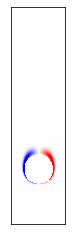

In [2]:
seed(42)

# Simulation parameters
Nx          = 400    # resolution x-dir
Ny          = 100    # resolution y-dir
rho0        = 100    # average density
tau         = 0.6    # collision timescale
Nt          = 200    # number of timesteps

# Lattice speeds / weights
NL = 9
cxs = [0, 0, 1, 1, 1, 0,-1,-1,-1]
cys = [0, 1, 1, 0,-1,-1,-1, 0, 1]
weights = [4/9,1/9,1/36,1/9,1/36,1/9,1/36,1/9,1/36]
reflections = [0, 5, 6, 7, 8, 1, 2, 3, 4]

F = [[[1 for x in range(NL)] for x in range(Ny)] for x in range(Nx)]

boundaryF = [[[1 for x in range(NL)] for x in range(Ny)] for x in range(Nx)]

for i in range(Nx):
    for j in range(Ny):
        F[i][j][3] += 2 * (1+0.2*cos(2*pi*i/Nx*4))
        for l in range(NL):
            F[i][j][l] += 0.01*RandomGaussian(1)[0]


rho = [[0 for x in range(Ny)] for x in range(Nx)]
u = [[0 for x in range(Ny)] for x in range(Nx)]
v = [[0 for x in range(Ny)] for x in range(Nx)]
vort = [[0 for x in range(Ny)] for x in range(Nx)]

for i in range(Nx):
    for j in range(Ny):
        for l in range(NL):
            rho[i][j] += F[i][j][l]
        for l in range(NL):
            F[i][j][l] *= rho0/rho[i][j]

cylinder = [[0 for x in range(Ny)] for x in range(Nx)]

for i in range(Nx):
    for j in range(Ny):
        if((i - Nx/4)**2 + (j - Ny/2)**2 < (Ny/4)**2):
            cylinder[i][j] = 1

for it in range(Nt):
    
    #Drift
    for l in range(NL):
        b = [[0 for x in range(Ny)] for x in range(Nx)]
        for i in range(Nx):
            for j in range(Ny):
                b[(i+cxs[l]+Nx)%Nx][(j+cys[l]+Ny)%Ny] = F[i][j][l]
        for i in range(Nx):
            for j in range(Ny):
                F[i][j][l] = b[i][j]

    #Set reflective boundary
    for i in range(Nx):
        for j in range(Ny):
            if(cylinder[i][j]==1):
                for l in range(NL):
                    boundaryF[i][j][l] = F[i][j][reflections[l]]

    #Calculate fluid variables
    for i in range(Nx):
        for j in range(Ny):
            rho[i][j] = 0
            for l in range(NL):
                rho[i][j] += F[i][j][l]

    for i in range(Nx):
        for j in range(Ny):
            u[i][j] = 0
            v[i][j] = 0
            for l in range(NL):
                u[i][j] += F[i][j][l]*cxs[l] /rho[i][j]
                v[i][j] += F[i][j][l]*cys[l] /rho[i][j]

    #Apply collision
    Feq = [[[0 for x in range(NL)] for x in range(Ny)] for x in range(Nx)]
    for i in range(Nx):
        for j in range(Ny):
            for l in range(NL):
                Feq[i][j][l] = rho[i][j]*weights[l]*(1+3*(cxs[l]*u[i][j] + cys[l]*v[i][j]) + 9/2*(cxs[l]*u[i][j] + cys[l]*v[i][j])**2 - 3/2*(u[i][j]*u[i][j] + v[i][j]*v[i][j]))
                F[i][j][l] += -(1/tau)*(F[i][j][l] - Feq[i][j][l])

    #Apply boundary
    for j in range(Ny):
        for i in range(Nx):
            if(cylinder[i][j]==1):
                for l in range(NL):
                    F[i][j][l] = boundaryF[i][j][l] 

    #Calculate vorticity for plotting (set velocity and vort in cylinder to 0)
    for i in range(Nx):
        for j in range(Ny):
            if(cylinder[i][j]==1):
                u[i][j] = 0
                v[i][j] = 0
    
    for i in range(Nx):
        for j in range(Ny):
            vort[i][j] = (u[i][(j+1+Ny)%Ny]-u[i][(j-1+Ny)%Ny]) - (v[(i+1+Nx)%Nx][j]-v[(i-1+Nx)%Nx][j])
            if(cylinder[i][j]==1):
                vort[i][j] = nan

    if((it % 1) == 0 or (it == Nt-1)):
        plt.cla()
        plt.imshow(vort, cmap='bwr')
        plt.clim(-.1, .1)
        ax = plt.gca()
        ax.invert_yaxis()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)	
        ax.set_aspect('equal')	